# Colorbot - training your own model


![img](imgs/colorbot_model.png)
![img](imgs/colorbot_execution.png)


## Dependencies

In [168]:
# Tensorflow
import tensorflow as tf
print('Tested with TensorFLow 1.2.0')
print('Your TensorFlow version:', tf.__version__) 

# Feeding function for enqueue data
from tensorflow.python.estimator.inputs.queues import feeding_functions as ff

# Rnn common functions
from tensorflow.contrib.learn.python.learn.estimators import rnn_common

# Run an experiment
from tensorflow.contrib.learn.python.learn import learn_runner

# Model builder
from tensorflow.python.estimator import model_fn as model_fn_lib

# Plot images with pyplot
%matplotlib inline
from matplotlib import pyplot as plt

# Helpers for data processing
import pandas as pd
import numpy as np
import argparse

Tested with TensorFLow 1.2.0
Your TensorFlow version: 1.2.0


## Parameters

In [169]:
# Data files
TRAIN_INPUT = 'data/train.csv'
TEST_INPUT = 'data/test.csv'
MY_TEST_INPUT = 'data/mytest.csv'

# Parameters for training
STEPS = 10000
BATCH_SIZE = 64

# Parameters for data processing
CHARACTERS = [chr(i) for i in range(256)]
SEQUENCE_LENGTH_KEY = 'sequence_length'
COLOR_NAME_KEY = 'color_name'
RGB_KEY = 'rgb'

## Helper functions

In [170]:
# This function creates a sparse tensor in the following way, given:
# indices = [[0, 0], [1, 1], [2, 2]]
# values = [1, 2, 3]
# dense_shape = [3, 4]
#
# The output will be a sparse tensor that represents this dense tensor:
# [ 
#   [1, 0, 0, 0]
#   [0, 2, 0, 0]
#   [0, 0, 3, 0]
# ]
#
# We're using this to generate a Sparse tensor that can be easily
# formated in a one hot representation.
# More at: https://www.tensorflow.org/api_docs/python/tf/SparseTensor
def _sparse_string_to_index(sp, mapping):
    # This operation constructs a lookup table to convert tensor of strings
    # into int64 IDs
    table = tf.contrib.lookup.index_table_from_tensor(mapping, dtype=tf.string)
    
    return tf.SparseTensor(indices=sp.indices,
                           values=table.lookup(sp.values),
                           dense_shape=sp.dense_shape)

# Returns the column values from a CSV file as a list
def _get_csv_column(csv_file, column_name):
    with open(csv_file, 'r') as f:
        df = pd.read_csv(f)
        return df[column_name].tolist()

# Plot a color image
def _plot_rgb(rgb):
    data = [[rgb]]
    plt.figure(figsize=(2,2))
    plt.imshow(data, interpolation='nearest')
    plt.show()

## Input functions

In [171]:
# Input function used for training and testing                                                
def get_input_fn(csv_file, batch_size, epochs=1):
   
    # loading csv in memory
    df = pd.read_csv(csv_file)
    df = df.dropna()
    
    # Sequence length is used by the Dynamic RNN
    # to dynamically unroll the graph :D!
    df['sequence_length'] = df.name.str.len().astype(np.int32)

    # We can use a canned input function for generating batches
    # with the pandas data frame, then we call it and
    # make the changes needed on the features
    pd_fn = tf.estimator.inputs.pandas_input_fn(df, shuffle=True,
                                                batch_size=batch_size,
                                                num_epochs=epochs,
                                                queue_capacity=100000)
    
    def input_fn():   
        # calling the pandas input function
        fields = argparse.Namespace(**pd_fn())
        
        # Split strings into chars
        split_color_name = tf.string_split(fields.name, delimiter='')
        # Creating a tf constant to hold the map char -> index
        # this is need to create the sparse tensor and after the one hot encode
        table = tf.contrib.lookup.index_table_from_tensor(CHARACTERS, dtype=tf.string)
        # Names represented in a sparse tensor
        integerized_color_name = table.lookup(split_color_name)
        
        # Tensor of normalized RGB values
        rgb = tf.to_float(tf.stack([fields.red, fields.green, fields.blue], axis=1)) / 255.0

        features = {COLOR_NAME_KEY: integerized_color_name, SEQUENCE_LENGTH_KEY: fields.sequence_length}
        return features, rgb

    return input_fn

In [172]:
# Creating my own input function for a custom CSV file
# it's simpler than the input_fn above but just used for small tests
def my_test_input_fn():
    df = pd.read_csv(MY_TEST_INPUT)
    df = df.dropna()
    df['sequence_length'] = df.name.str.len().astype(np.int32)

    color_name = df.name.tolist()

    split_color_name = tf.string_split(color_name, delimiter='')
    mapping = tf.constant(CHARACTERS, name="mapping")
    integerized_color_name = _sparse_string_to_index(split_color_name, mapping)

    x = {COLOR_NAME_KEY: integerized_color_name, SEQUENCE_LENGTH_KEY: df.sequence_length.tolist()}

    y = np.asarray([[0, 0, 0]], dtype=np.float32)

    return x, y

In [173]:
train_input_fn = get_input_fn(TRAIN_INPUT, BATCH_SIZE)
test_input_fn = get_input_fn(TEST_INPUT, BATCH_SIZE)

## Creating the Estimator model

In [181]:
def get_model_fn(rnn_cell_sizes,
                 label_dimension,
                 dnn_layer_sizes=[],
                 optimizer='SGD',
                 learning_rate=0.01):
    
    def model_fn(features, labels, mode):
        
        color_name = features[COLOR_NAME_KEY]
        sequence_length = features[SEQUENCE_LENGTH_KEY]

        # Creating dense representation for the names
        # and then converting it to one hot representation
        dense_color_name = tf.sparse_tensor_to_dense(color_name, default_value=len(CHARACTERS))
        color_name_onehot = tf.one_hot(dense_color_name, depth=len(CHARACTERS) + 1)
        
        # Each RNN layer will consist of a LSTM cell
        rnn_layers = [tf.contrib.rnn.LSTMCell(size) for size in rnn_cell_sizes]
        
        # Construct the layers
        multi_rnn_cell = tf.contrib.rnn.MultiRNNCell(rnn_layers)
        
        # Runs the RNN model dynamically
        # more about it at: 
        # https://www.tensorflow.org/api_docs/python/tf/nn/dynamic_rnn
        outputs, final_state = tf.nn.dynamic_rnn(cell=multi_rnn_cell,
                                                 inputs=color_name_onehot,
                                                 sequence_length=sequence_length,
                                                 dtype=tf.float32)

        # Slice to keep only the last cell of the RNN
        last_activations = rnn_common.select_last_activations(outputs,
                                                              sequence_length)

        # Construct dense layers on top of the last cell of the RNN
        for units in dnn_layer_sizes:
            last_activations = tf.layers.dense(
              last_activations, units, activation=tf.nn.relu)
        
        # Final dense layer for prediction
        predictions = tf.layers.dense(last_activations, label_dimension)

        loss = None
        train_op = None

        if mode != tf.contrib.learn.ModeKeys.INFER:    
            loss = tf.losses.mean_squared_error(labels, predictions)
    
        if mode == tf.contrib.learn.ModeKeys.TRAIN:    
            train_op = tf.contrib.layers.optimize_loss(
              loss,
              tf.contrib.framework.get_global_step(),
              optimizer=optimizer,
              learning_rate=learning_rate)
        
        return model_fn_lib.EstimatorSpec(mode,
                                           predictions=predictions,
                                           loss=loss,
                                           train_op=train_op)
    return model_fn

In [189]:
model_fn = get_model_fn(rnn_cell_sizes=[256, 128], # size of the hidden layers
                        label_dimension=3, # since is RGB
                        dnn_layer_sizes=[128], # size of units in the dense layers on top of the RNN
                        optimizer='Adam', #changing optimizer to Adam
                        learning_rate=0.01)

estimator = tf.estimator.Estimator(model_fn=model_fn, model_dir='/tmp/colorbot_model')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_steps': None, '_model_dir': '/tmp/colorbot_model', '_tf_random_seed': 1, '_keep_checkpoint_every_n_hours': 10000, '_save_checkpoints_secs': 600, '_save_summary_steps': 100, '_session_config': None, '_keep_checkpoint_max': 5}


## Trainning and Evaluating

In [190]:
NUM_EPOCHS = 10
for i in range(NUM_EPOCHS):
    print('Training epoch %d' % i)
    print('-' * 20)
    estimator.train(input_fn=train_input_fn)
    print('Evaluating epoch %d' % i)
    print('-' * 20)
    estimator.evaluate(input_fn = test_input_fn)

Training epoch 0
--------------------


/usr/local/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/colorbot_model/model.ckpt.
INFO:tensorflow:step = 1, loss = 0.365346
INFO:tensorflow:Saving checkpoints for 19 into /tmp/colorbot_model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.10139.
Evaluating epoch 0
--------------------
INFO:tensorflow:Starting evaluation at 2017-06-20-21:58:43
INFO:tensorflow:Restoring parameters from /tmp/colorbot_model/model.ckpt-19
INFO:tensorflow:Finished evaluation at 2017-06-20-21:58:43
INFO:tensorflow:Saving dict for global step 19: global_step = 19, loss = 0.0888186
Training epoch 1
--------------------
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/colorbot_model/model.ckpt-19
INFO:tensorflow:Saving checkpoints for 20 into /tmp/colorbot_model/model.ckpt.
INFO:tensorflow:step = 20, loss = 0.100648
INFO:tensorflow:Saving checkpoints for 38 into /tmp/colorbot_model/model.ckpt.
INFO:tensorflow:Loss for final step

## Making Predictions


INFO:tensorflow:Restoring parameters from /tmp/colorbot_model/model.ckpt-190
orange rgb (194, 118, 47)


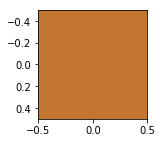

tensorflow orange rgb (208, 117, 19)


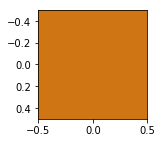

adfgasdgasd rgb (166, 130, 96)


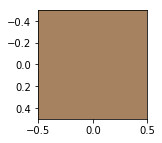

purple blue rgb (21, 124, 212)


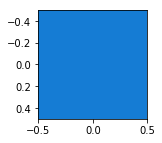

purple red rgb (203, 37, 56)


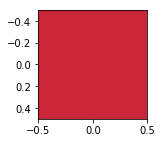

purple rgb (118, 88, 115)


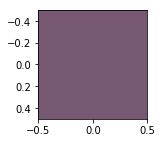

water rgb (187, 167, 142)


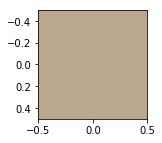

pink rgb (189, 139, 155)


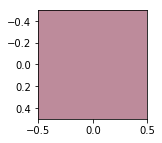

rock rgb (133, 109, 77)


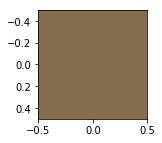

In [193]:
preds = estimator.predict(input_fn=my_test_input_fn)

color_names = _get_csv_column(MY_TEST_INPUT, 'name')

print()
for p, name in zip(preds, color_names):
    color = tuple(map(int, p * 255))
    print(name, 'rgb', color)
    _plot_rgb(p)

## Pre-trained model predictions

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_steps': None, '_model_dir': 'pretrained', '_tf_random_seed': 1, '_keep_checkpoint_every_n_hours': 10000, '_save_checkpoints_secs': 600, '_save_summary_steps': 100, '_session_config': None, '_keep_checkpoint_max': 5}

INFO:tensorflow:Restoring parameters from pretrained/model.ckpt-10020
orange rgb (249, 89, 4)


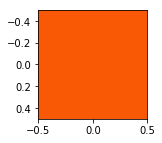

tensorflow orange rgb (243, 99, 40)


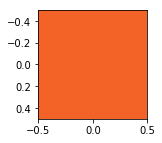

adfgasdgasd rgb (172, 152, 103)


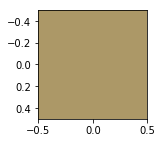

purple blue rgb (56, 50, 214)


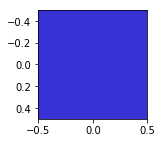

purple red rgb (168, 20, 69)


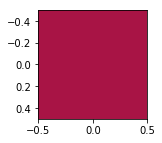

purple rgb (133, 49, 193)


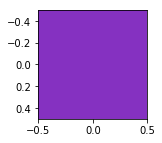

water rgb (148, 218, 240)


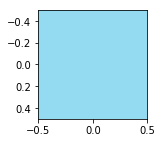

pink rgb (247, 123, 182)


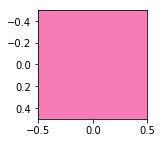

rock rgb (111, 46, 57)


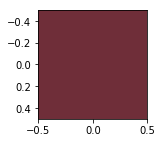

In [196]:
pre_estimator = estimator = tf.estimator.Estimator(model_dir='pretrained', model_fn=model_fn)
preds = pre_estimator.predict(input_fn=my_test_input_fn)

color_names = _get_csv_column(MY_TEST_INPUT, 'name')

print()
for p, name in zip(preds, color_names):
    color = tuple(map(int, p * 255))
    print(name, 'rgb', color)
    _plot_rgb(p)